In [22]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline   
plt.rcParams['image.cmap'] = 'gray'

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn import linear_model, datasets, metrics
from scipy.ndimage import convolve

In [2]:
def gen_mnist_image(X):
    return np.rollaxis(np.rollaxis(X[0:200].reshape(20, -1, 28, 28), 0, 2), 1, 3).reshape(-1, 20 * 28)

In [24]:
df = pd.read_csv(r'C:\Users\Rahul Miglani\Untitled Folder 2\fashion_train.csv')

In [25]:
df.shape

(60000, 785)

In [26]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
df.label.unique()

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1], dtype=int64)

In [28]:
df.label.value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

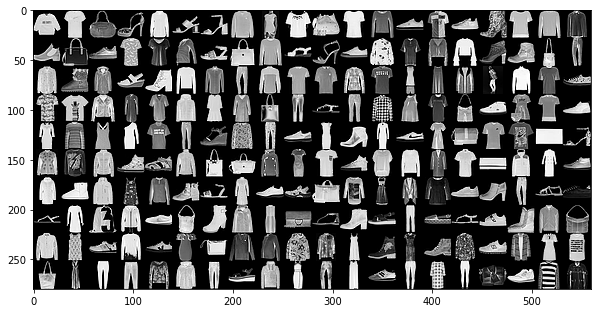

In [29]:
plt.figure(figsize=(10,20))
plt.imshow(gen_mnist_image(df.values[:,1:]));

In [30]:
df.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000
mean,4.500000,0.000900,0.006150,0.035333,0.101933,0.247967,0.411467,0.805767,2.198283,5.682000,...,34.625400,23.300683,16.588267,17.869433,22.814817,17.911483,8.520633,2.753300,0.855517,0.07025
std,2.872305,0.094689,0.271011,1.222324,2.452871,4.306912,5.836188,8.215169,14.093378,23.819481,...,57.545242,48.854427,41.979611,43.966032,51.830477,45.149388,29.614859,17.397652,9.356960,2.12587
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,4.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,58.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,9.000000,16.000000,36.000000,226.000000,164.000000,227.000000,230.000000,224.000000,255.000000,254.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,170.00000


In [31]:
X = df.iloc[:,1:758]
Y = df.label

In [32]:
X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)  # 0-1 scaling

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0)


In [33]:
# Models we will use
logistic = linear_model.LogisticRegression(solver='newton-cg', tol=1)
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

In [34]:
# Training

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.06
rbm.n_iter = 10
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.
raw_pixel_classifier.fit(X_train, Y_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -227.72, time = 13.34s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -219.72, time = 13.76s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -216.73, time = 13.36s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -214.30, time = 13.34s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -210.82, time = 13.74s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -210.99, time = 13.51s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -205.84, time = 13.26s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -211.26, time = 13.62s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -207.25, time = 14.48s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -209.33, time = 14.33s


C:\Users\Rahul Miglani\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Rahul Miglani\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=1, verbose=0,
                   warm_start=False)

In [36]:
# Evaluation

Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

Y_pred = raw_pixel_classifier.predict(X_test)
print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))


Logistic regression using RBM features:
              precision    recall  f1-score   support

           0       0.73      0.81      0.77      1189
           1       0.99      0.94      0.96      1189
           2       0.60      0.63      0.61      1204
           3       0.80      0.85      0.82      1260
           4       0.60      0.60      0.60      1208
           5       0.96      0.88      0.92      1188
           6       0.52      0.43      0.47      1195
           7       0.89      0.89      0.89      1160
           8       0.92      0.95      0.93      1210
           9       0.89      0.94      0.91      1197

    accuracy                           0.79     12000
   macro avg       0.79      0.79      0.79     12000
weighted avg       0.79      0.79      0.79     12000


Logistic regression using raw pixel features:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1189
           1       0.96      0.96      0.96  

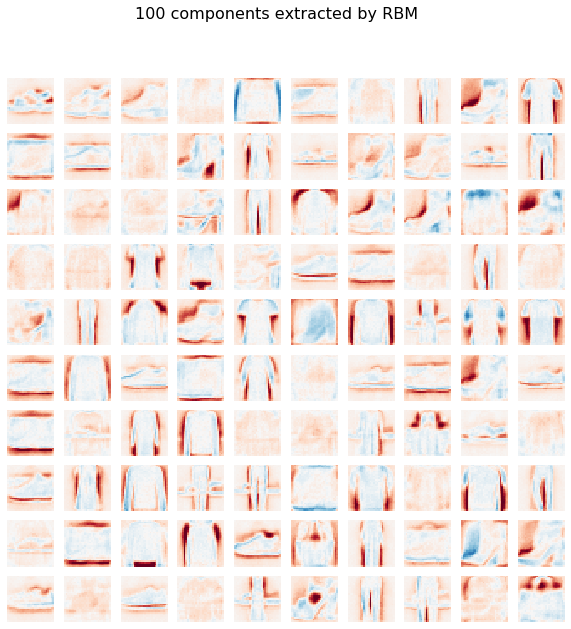

In [76]:
plt.figure(figsize=(10, 10))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((28, 28)), cmap=plt.cm.RdBu,
               interpolation='nearest', vmin=-2.5, vmax=2.5)
    plt.axis('off')
plt.suptitle('100 components extracted by RBM', fontsize=16);

The above image represents the features or the pixels extracted by the RBM. 